---
# Introduction <a name="introduction"></a>

This notebook provides a comprehensive guide for managing prompt template assets developed with Language Models (LLMs) deployed on third-party platforms such as Bedrock and Azure. It aims to demonstrate the complete process of creating and evaluating prompt template assets to compute essential metrics.

The notebook covers the entire workflow, from the creation of prompt template assets to their evaluation, ensuring a thorough understanding of both the setup and assessment phases.


`Detached Prompt Evalution`


The detached prompt is evaluated using a sample insurance claims dataset. This dataset includes `generated_text` and `prompt_variable`, which is used for evaluation.

You can download the evaluations sample dataset [Insurance claims scored payload data with reference data](path/to/your/insurance_claims_dataset.csv).


For detailed documentation on these features, please refer to the [IBM AI Factsheet documentation](https://s3.us.cloud-object-storage.appdomain.cloud/aifactsheets-client/index.html).


**Required Services:**
- `watsonx.governance`
- `watsonx.ai`

**Required Packages:**
- **IBM Facts Client Python SDK (>=1.0.80)**
- **IBM-watsonx-ai Python SDK**
- **IBM-watson-openscale Python SDK**




In [1]:
!pip install ibm-watsonx-ai --quiet
!pip install -U python-dotenv --quiet
!pip install ibm-aigov-facts-client --quiet
!pip install ibm-watson-openscale  --quiet

In [1]:
import warnings
#import wget
import os
import shutil
from IPython.core.display import display, Markdown
from ibm_aigov_facts_client import AIGovFactsClient,CloudPakforDataConfig,DetachedPromptTemplate,PromptTemplate
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials

warnings.filterwarnings('ignore')
load_dotenv()

/tmp/wsuser/ipykernel_715/3758210307.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Markdown


- This sample will use IBM Cloud by default. If you prefer to IBM watsonx.goverance software, set `use_software=True`
- Flag `run_cleanup_at_end` offers option to delete created assets at the end of the notebook.The notebook will show URL to UI for model and model use case at certain cells. By dafault we set it to `run_cleanup_at_end=False` so you can access UI and see the changes. If you decide to cleanup assets at the end, set `run_cleanup_at_end=True` and remember cells showing links to UI will `NOT` work in that case.

In [2]:
use_software=False
run_cleanup_at_end=True

- Model container type can be `space` or `project`. 

In [3]:
container_type="project"
project_id=os.getenv("CONTAINER_ID","if you can't use .env you can provide your value here") # Project_id where the model has to store 

---
## Authentication Setup<a name="setup"></a>

### IBM Cloud  <a name="IBM-Cloud"></a>

Your Cloud API key can be generated by going to the Users section of the Cloud console. From that page, go to **Manage->Access(IAM)->API keys-> Create**. Give your key a name and click Create, then copy the created key and use as API_KEY.

NOTE: You can also get OpenScale API_KEY using IBM CLOUD CLI.

How to install IBM Cloud (bluemix) console: instruction

How to get api key using console:

```
bx login --sso
bx iam api-key-create 'my_key'
```
- Get relevant space id from UI `(Deployments -> Spaces-> open space -> Manage -Space GUID)`

In [4]:
if not use_software:
    API_KEY=os.getenv("CLOUD_API_KEY","if you can't use .env you can provide your value here")

[back to top](#introduction)
### IBM watsonx.goverance software<a name="Watsonx.Gov-Platform"></a>

- Service url is the watsonx.goverance software platform host URL. For skytap environment, it would be the internal nginx URL.
- You can either use user `password` or platform `apikey` to authenticate

In [5]:
if use_software:
    creds=CloudPakforDataConfig(service_url=os.getenv("CPD_SERVICE_URL", "<if you can't use .env you can provide your value here>"),
        username=os.getenv("CPD_USERNAME", "<if you can't use .env you can provide your value here>"),
        password=os.getenv("CPD_PASSWORD", "<if you can't use .env you can provide your value here>"))

## Client Initialization
- Container type would be either `space` or `project`. To use get/set environment utilities, model asset should be stored in Space.
- If running this notebook multiple times with same experiment name or anytime face error saying `Experiment with same name already exists`, use `set_as_current_experiment=True` when initiating client





In [6]:
if use_software:
   facts_client = AIGovFactsClient(cloud_pak_for_data_configs=creds,container_type=container_type,container_id=project_id,disable_tracing=True)
else: 
   facts_client = AIGovFactsClient(api_key=API_KEY,container_type=container_type,container_id=project_id,disable_tracing=True)

In [7]:
facts_client.version 

'1.0.139'

---
## Creating Detached Prompt <a name="Creating-a-Detached-Prompt"></a>

In creating a Detached Prompt, there are two primary classes to consider:

- **DetachedPromptTemplate**
- **PromptTemplate** (optional)

### Detached Prompt <a name="Detached-Template"></a>

A detached prompt template is an asset used to evaluate a prompt template for a language prompt hosted by third-party providers like Google Vertex AI, Azure OpenAI, or AWS Bedrock. The output is generated on the remote model, while evaluation is conducted using `watsonx.governance` metrics. You can also track the detached deployment and prompt template as part of your AI governance solution.

You add parts of your prompt into the appropriate fields by adding it to `DetachedPromptTemplate`:

- **prompt_id**: Identifier for the prompt, applicable as supported by the provider.
- **model_id**: Unique identifier for the provisioned model, often in ARN or equivalent format.
- **model_provider**: The provider of the model.
- **model_name**: The name of the model being used.
- **model_url**: Link to the model's documentation or additional resources.
- **prompt_url**: URL for the prompt, if supported by the provider.
- **prompt_additional_info**: Dictionary for any supplementary information relevant to the prompt, such as configuration settings.


**Note:** When providing Detached information:
- **Model Information:** You need to include both `model_name` and `model_url`. If you leave one out, you should leave both out.
- **Prompt Information:** The same applies to `prompt_url` and `prompt_additional_info`.


In [8]:
# define parameters for DetachedPromptTemplate

detached_information =DetachedPromptTemplate(
    prompt_id="<prompt id when supported by provider>", 
    model_id="arn:aws:bedrock:us-east1:123456789012:provisioned-model/anthropic.claude-v2",
    model_provider="AWS Bedrock",
    model_name="Anthropic Claude 2.0",
    model_url="https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-claude.html",
    prompt_url="<prompt url when supported by provider>",
    prompt_additional_info={"AWS Region": "us-east1"}
)

### Prompt Template <a name="Prompt-Template"></a>
The `PromptTemplate` class is designed to create and manage templates for prompts.It includes a variety of parameters to configure the prompt template comprehensively. 

You add parts of your prompt into the appropriate fields by adding it to `PromptTemplate`:

- **Input**: The text or data you provide as the starting point for the prompt. This is the information the model will work with.
  
- **Prompt Variables**: A prompt variable is a placeholder keyword that you include in the static text of your prompt at creation time and replace with text dynamically at run time.

- **Model Parameters**: These settings control how the model generates responses. For example:

  - `decoding_method`: "greedy"
  - `max_new_tokens`: 2034
  - `min_new_tokens`: 0
  - `random_seed`: 0
  - `top_k`: 0
  - `top_p`: 0

In [9]:
model_parameter={"decoding_method":"greedy",
                 "max_new_tokens":2034,
                 "min_new_tokens":0,
                 "random_seed":0,
                 "top_k":0,
                 "top_p":0
                }

In [10]:
prompt_variables={"text": "value" }

In [11]:
prompt_template = PromptTemplate(
                                 prompt_variables=prompt_variables,
                                 input="Input text to be given ",

                                 model_parameters=model_parameter
                                 
                                )

### Setting Up a Detached Prompt

The `facts_client.assets.create_detached_prompt` function is used to create a detached prompt.

#### Parameter Descriptions for Detached Prompt

- **task_id**: Specifies the task the prompt is designed for:
  - **question_answering**: Generates answers to questions.
  - **summarization**: Condenses content into a brief summary.
  - **retrieval_augmented_generation**: Combines information retrieval with generation.
  - **classification**: Categorizes text.
  - **generation**: Creates new content.
  - **code_generation_and_conversion**: Generates or converts code.
  - **extraction**: Pulls out specific information.
  - **translation**: Converts text from one language to another.

- **model_id**: Specifies the model used to create the detached prompt.

- **name**: A label for easy identification of the prompt.

- **description**: A brief explanation of the prompt's purpose, used for documentation.

- **detached_information**: Contains the prompt template detailing how the detached prompt should be defined.

- **prompt_details**: Further outlines specifics for defining the prompt.


In [12]:
model_id="anthropic.claude-v2"
task_id = "summarization" 
name="External prompt sample (model AWS Bedrock Anthropic)"
description="My first detached prompt"

In [13]:
detached_prompt=facts_client.assets.create_detached_prompt(model_id=model_id,task_id=task_id, name=name, description=description,prompt_details=prompt_template, detached_information=detached_information)

2024/08/12 12:19:11 INFO : ------------------------------ Detached Prompt Creation Started ------------------------------
2024/08/12 12:19:12 INFO : The detached prompt with ID 5ce40116-372e-4766-976c-fcb9d9c06df2 was created successfully in container_id 16ecf1b6-ab3f-4840-bb90-6748e2251891.


In [14]:
detached_prompt.get_info(verbose=True)


2024/08/12 12:19:13 INFO : The link to access the prompt created is: https://dataplatform.cloud.ibm.com/wx/prompt-details/5ce40116-372e-4766-976c-fcb9d9c06df2/factsheet?project_id=16ecf1b6-ab3f-4840-bb90-6748e2251891&context=wx
2024/08/12 12:19:13 INFO : 
Prompt Details:
  id: 5ce40116-372e-4766-976c-fcb9d9c06df2
  name: External prompt sample (model AWS Bedrock Anthropic)
  input mode: detached
  model_id: anthropic.claude-v2
  container ID: 16ecf1b6-ab3f-4840-bb90-6748e2251891
  description: My first detached prompt
  created By: IBMid-6910001S2E
  model_version: {}
  prompt_variables: {'text': {'default_value': 'value'}}
  task_id: ['summarization']
  instruction: 
  input_prefix: 
  output_prefix: 
  structured_examples:
  input:
    ['Input text to be given ', '']

  model_parameters:
     decoding_method: greedy
     max_new_tokens: 2034
     min_new_tokens: 0
     random_seed: 0
     stop_sequences: []
     temperature: 
     top_k: 0
     top_p: 0
     repetition_penalty: 

  d

#### Fetch the asset_id of the prompt

In [15]:
#extract the assest_id from above 

asset_id=detached_prompt.get_asset_id()
print(asset_id)


5ce40116-372e-4766-976c-fcb9d9c06df2


##### You can also retrieve existing prompts by their ID.

In [ ]:
asset_id="********"
detached_prompt=facts_client.assets.get_prompt(asset_id)

---
## Evaluate Prompt Template in Project

Evaluating a prompt template within a project involves using the Watson OpenScale client to assess its effectiveness. This process includes accessing the client, selecting the appropriate project, and locating the prompt template to be evaluated


For further details, consult the [Watson OpenScale Documentation](https://www.ibm.com/docs/en/ibm-watson-openscale)


### Intialize Watson OpenScale Client

In [16]:
cloud_iam_url = os.getenv("cloud_iam_url", "<if you can't use .env you can provide your value here>")
openscale_service_url =os.getenv("openscale_service_url", "<if you can't use .env you can provide your value here>")
service_instance_id =os.getenv("service_instance_id", "<if you can't use .env you can provide your value here>")

In [17]:
# Configure OpenScale
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


authenticator = IAMAuthenticator(apikey=API_KEY, url = cloud_iam_url)
wos_client = APIClient(authenticator=authenticator, service_url = openscale_service_url,service_instance_id =service_instance_id)
wos_client.version

'3.0.39'

### Set Up the Prompt Template Asset in Project for Evaluation

To set up the prompt template asset for evaluation, ensure it is configured with the supported monitor dimensions. The monitor dimensions required can vary depending on the task type. For detailed information on the different monitor dimensions supported for various tasks, refer to the [Watson OpenScale Monitor Dimensions Documentation](https://github.com/IBM/watson-openscale-samples/blob/main/IBM%20Cloud/WML/notebooks/watsonx/README.md).


In [20]:
label_column ="reference_output"
operational_space_id = "development"
problem_type= task_id
input_data_type= "unstructured_text"
classification_type="multiclass"


monitors = {
     "generative_ai_quality": {
            "parameters": {
        
                "min_sample_size": 10,
                "metrics_configuration":{
                    
                "bleu": {
                    "max_order": 4,
                    "smooth": "false"
                },
                "cosine_similarity": {},
                "hap_score": {
                    "record_level_max_score": 0.5
                },
                "jaccard_similarity": {},
                "meteor": {
                    "alpha": 0.9,
                    "beta": 3,
                    "gamma": 0.5
                },
                "normalized_f1": {},
                "normalized_precision": {},
                "normalized_recall": {},
                "rouge_score": {
                    "use_aggregator": "true",
                    "use_stemmer": "true"
                },
                "sari": {},
                "pii": {
                  "record_level_max_score": 0.5
                 }
                        
                }
    }
}
}

response = wos_client.wos.execute_prompt_setup(prompt_template_asset_id = asset_id, 
                                                                   project_id = project_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   classification_type=classification_type,
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 5ce40116-372e-4766-976c-fcb9d9c06df2 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '5ce40116-372e-4766-976c-fcb9d9c06df2',
 'project_id': '16ecf1b6-ab3f-4840-bb90-6748e2251891',
 'deployment_id': '155d255d-7268-4c5e-a2dd-a57889f38313',
 'service_provider_id': '94bde04a-6019-44f8-bfc6-485e1a7365f3',
 'subscription_id': '9b15db45-68a4-4808-a199-66fd7af79118',
 'mrm_monitor_instance_id': '19fb794b-2c1d-43ae-b0ee-1feceabfe1ab',
 'start_time': '2024-08-12T12:19:50.132020Z',
 'end_time': '2024-08-12T12:20:01.615558Z',
 'status': {'state': 'FINISHED'}}

### Check Status

In [24]:
response = wos_client.wos.get_prompt_setup(prompt_template_asset_id =asset_id,
                                           project_id = project_id)

result = response.result
result_json = result._to_dict()


if result_json["status"]["state"] == "FINISHED":
    print("Finished prompt setup : The response is {}".format(result_json))
else:
    print("prompt setup failed The response is {}".format(result_json))

Finished prompt setup : The response is {'prompt_template_asset_id': '5ce40116-372e-4766-976c-fcb9d9c06df2', 'project_id': '16ecf1b6-ab3f-4840-bb90-6748e2251891', 'deployment_id': '155d255d-7268-4c5e-a2dd-a57889f38313', 'service_provider_id': '94bde04a-6019-44f8-bfc6-485e1a7365f3', 'subscription_id': '9b15db45-68a4-4808-a199-66fd7af79118', 'mrm_monitor_instance_id': '19fb794b-2c1d-43ae-b0ee-1feceabfe1ab', 'start_time': '2024-08-12T12:19:50.132020Z', 'end_time': '2024-08-12T12:20:01.615558Z', 'status': {'state': 'FINISHED'}}


### Get Subscription ID

To proceed with the evaluation, you will need the Subscription ID.

In [25]:
dev_subscription_id = result_json["subscription_id"]
dev_subscription_id

'9b15db45-68a4-4808-a199-66fd7af79118'

### Display Watson OpenScale Monitor Instances

To ensure proper functionality, display the Watson OpenScale Monitor instances associated with your project. Each instance should be in the "active" status. Confirming that all instances are active is crucial for accurate monitoring and evaluation of your prompt template. If any instance is not active, address the issue to ensure continuous and effective monitoring.


In [26]:
wos_client.monitor_instances.show(target_target_id = dev_subscription_id)

6b080d51-336b-4e2f-a314-24902b36881a,active,9b15db45-68a4-4808-a199-66fd7af79118,subscription,generative_ai_quality,2024-08-12 12:19:54.989000+00:00,3f67905b-429a-4443-ae0e-e5c239264578
6b080d51-336b-4e2f-a314-24902b36881a,active,9b15db45-68a4-4808-a199-66fd7af79118,subscription,model_health,2024-08-12 12:19:55.663000+00:00,371f6261-9af0-45a0-93cc-901562511689
6b080d51-336b-4e2f-a314-24902b36881a,active,9b15db45-68a4-4808-a199-66fd7af79118,subscription,mrm,2024-08-12 12:19:56.550000+00:00,19fb794b-2c1d-43ae-b0ee-1feceabfe1ab


In [27]:
data_mart_id = "6b080d51-336b-4e2f-a314-24902b36881a" # Fill in here your data_mart_id from above table

### Upload Test Data for Evaluation

To proceed with the evaluation, upload the necessary test data to the project. Ensure that the test data is correctly placed and accessible within the project environment. After uploading, fill in the `test_data_path` with the accurate path to the test data file. Properly specifying the `test_data_path` is essential for the evaluation process to access and utilize the test data effectively.


In [29]:
test_data_path = "Insurance claims scored payload data with reference data (3).csv"
body = None # Please update your mapping file path here if needed

# Download feedback data from project to local directory
# Run the below code snippet only if you are running the notebook via watson studio
from ibm_watson_studio_lib import access_project_or_space
if use_software:
    wslib = access_project_or_space()
else:
    wslib = access_project_or_space({"token":facts_client.get_access_token()})
wslib.download_file(test_data_path)
if body:
    wslib.download_file(body)

### Get Monitor Risk Management (MRM) ID

To facilitate the evaluation, you need to obtain the Monitor Risk Management (MRM) ID. This ID is crucial for tracking and managing the risk associated with your monitors. Ensure you retrieve the correct MRM ID to ensure proper monitoring and risk management throughout the evaluation process.


In [30]:
monitor_definition_id = "mrm"
target_target_id = dev_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           project_id=project_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'19fb794b-2c1d-43ae-b0ee-1feceabfe1ab'

### Run Evaluation of the Detached Prompt on Uploaded Test Data

To evaluate the detached prompt, run the evaluation process using the uploaded test data. Ensure that the test data is correctly linked and accessible.


In [31]:
test_data_set_name = "data"
content_type = "multipart/form-data"

response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
                                                    test_data_set_name = test_data_set_name, 
                                                    test_data_path = test_data_path,
                                                    content_type = content_type,
                                                    body = body,
                                                    project_id = project_id,
                                                    background_mode = False)




 Waiting for risk evaluation of MRM monitor 19fb794b-2c1d-43ae-b0ee-1feceabfe1ab 




upload_in_progress
running...
finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### Check Status of Evaluation

In [32]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, project_id = project_id)
response.result.to_dict()

{'metadata': {'id': 'd527e6a9-3a85-40ba-bae2-0807fb5c092a',
  'created_at': '2024-08-12T12:21:37.848Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'evaluation_start_time': '2024-08-12T12:21:29.234108Z',
   'evaluator_user_key': '83278edb-957e-4f1f-bfc4-b6eaa01507b4',
   'facts': {'state': 'finished'},
   'is_auto_evaluated': False,
   'measurement_id': 'cff4acca-acd9-43a9-8b7b-65566932ccba',
   'project_id': '16ecf1b6-ab3f-4840-bb90-6748e2251891',
   'prompt_template_asset_id': '5ce40116-372e-4766-976c-fcb9d9c06df2',
   'user_iam_id': 'IBMid-6910001S2E',
   'wos_created_deployment_id': '155d255d-7268-4c5e-a2dd-a57889f38313',
   'publish_metrics': 'false',
   'evaluation_tests': ['drift_v2',
    'generative_ai_quality',
    'model_health',
    'quality']},
  'status': {'state': 'finished',
   'queued_at': '2024-08-12T12:21:37.837000Z',
   'started_at': '2024-08-12T12:21:38.605000Z',
   'updated_at': '2024-0

In [33]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, project_id=project_id)

2024-08-12 12:21:37.942000+00:00,tests_passed,cff4acca-acd9-43a9-8b7b-65566932ccba,1.0,None,None,['test_data_set_name:data'],mrm,19fb794b-2c1d-43ae-b0ee-1feceabfe1ab,d527e6a9-3a85-40ba-bae2-0807fb5c092a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:37.942000+00:00,tests_run,cff4acca-acd9-43a9-8b7b-65566932ccba,1.0,None,None,['test_data_set_name:data'],mrm,19fb794b-2c1d-43ae-b0ee-1feceabfe1ab,d527e6a9-3a85-40ba-bae2-0807fb5c092a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:37.942000+00:00,tests_skipped,cff4acca-acd9-43a9-8b7b-65566932ccba,2.0,None,None,['test_data_set_name:data'],mrm,19fb794b-2c1d-43ae-b0ee-1feceabfe1ab,d527e6a9-3a85-40ba-bae2-0807fb5c092a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:37.942000+00:00,tests_failed,cff4acca-acd9-43a9-8b7b-65566932ccba,0.0,None,None,['test_data_set_name:data'],mrm,19fb794b-2c1d-43ae-b0ee-1feceabfe1ab,d527e6a9-3a85-40ba-bae2-0807fb5c092a,subscription,9b15db45-68a4-4808-a199-66fd7af79118


### Display Calculated Generative AI Quality Metrics

To assess the performance of your Generative AI models, display the calculated quality metrics. Note that these metrics are not available for tasks of the type `Classification`. For other task types, reviewing these metrics provides valuable insights into the model's effectiveness and helps guide further optimization and improvements.


In [34]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           project_id = project_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'3f67905b-429a-4443-ae0e-e5c239264578'

Displaying the GenAIQ monitor metrics generated through the risk evaluation.

In [35]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, project_id=project_id)

2024-08-12 12:21:54.034754+00:00,normalized_recall,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,rouge2,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,records_processed,c128e156-da59-4a0b-ae95-c524a432007c,18.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,jaccard_similarity,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,meteor,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,rougelsum,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,hap_score,c128e156-da59-4a0b-ae95-c524a432007c,0.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,pii,c128e156-da59-4a0b-ae95-c524a432007c,0.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,normalized_precision,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118
2024-08-12 12:21:54.034754+00:00,bleu,c128e156-da59-4a0b-ae95-c524a432007c,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,3f67905b-429a-4443-ae0e-e5c239264578,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,subscription,9b15db45-68a4-4808-a199-66fd7af79118


Note: First 10 records were displayed.




### Display Record-Level Metrics for Generative AI Quality

To gain detailed insights into the performance of your Generative AI model, display the record-level metrics for Generative AI Quality. 

#### Read the dataset id for generative ai quality dataset

In [36]:
result = wos_client.data_sets.list(target_target_id = dev_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'ddefa2a9-79f8-4a9d-a6fb-6fd4368618cc'

#### Displaying record level metrics for generative ai quality

In [37]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-15,1.0,feedback,2024-08-12T12:21:31.870Z,0.9999271030762502,1.0,0.009350654669106007,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,1.0000000000000007,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-16,1.0,feedback,2024-08-12T12:21:31.870Z,0.9999772230320699,1.0,0.0012455952819436789,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,0.999999999999999,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-17,1.0,feedback,2024-08-12T12:21:31.870Z,0.9999745973682873,1.0,0.0014291518600657582,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,1.0,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-0,1.0,feedback,2024-08-12T12:21:31.869Z,0.9999638310185185,1.0,0.0012747134314849973,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,0.9999999999999991,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-1,1.0,feedback,2024-08-12T12:21:31.869Z,0.999958905235473,1.0,0.001430985634215176,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,1.0,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-10,1.0,feedback,2024-08-12T12:21:31.869Z,0.999968,1.0,0.000788102566730231,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,0.9999999999999999,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-11,1.0,feedback,2024-08-12T12:21:31.869Z,0.999968,1.0,0.0877394750714302,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,1.0000000000000002,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-12,1.0,feedback,2024-08-12T12:21:31.869Z,0.9999772230320699,1.0,0.0012455952819436789,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,0.999999999999999,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-13,1.0,feedback,2024-08-12T12:21:31.869Z,0.9999962307106618,1.0,0.0005029547610320151,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,0.9999999999999999,1.0
1.0,1.0,[],MRM_289ecce0-b8c0-43b1-864a-c81393131cab-14,1.0,feedback,2024-08-12T12:21:31.869Z,0.9998177842565598,1.0,0.003251601243391633,0.0,1.0,1.0,a9b69bdd-ccb2-471a-b79f-859618cc0d5a,1.0,1.0,100.0,1.0000000000000002,1.0


## Plot Rouge-L and Rouge-L Sum Metrics Against Records <a name="plotproject"></a>

To visualize the performance of your Generative AI model, plot the Rouge-L and Rouge-L Sum metrics against individual records. This plot will help you understand how well the model performs in terms of these metrics across different records. 

Rouge-L metrics assess the quality of generated text by comparing it to reference text, while Rouge-L Sum aggregates these scores to provide an overall view. Analyzing these plots can reveal patterns and areas for improvement in the model's performance.


In [38]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

#### Plot Rouge-L metrics against records


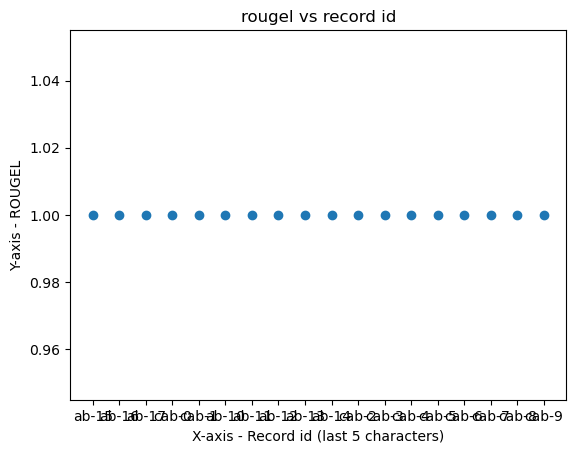

In [39]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

#### Plot Rouge-L Sum metrics against records

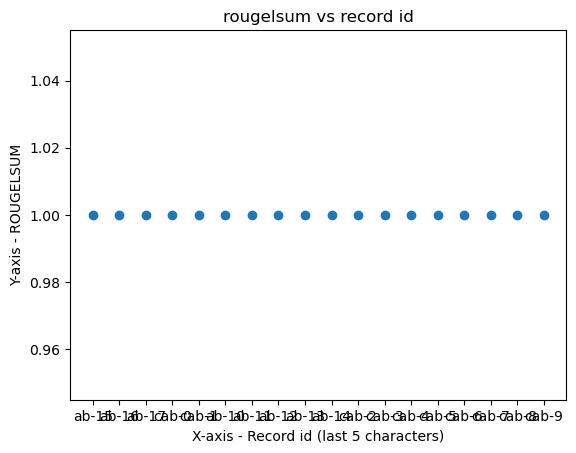

In [40]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

## View Factsheets Information <a name="factsheetsspace"></a>

To access detailed information about your models and evaluations, view the factsheets.

In [41]:
detached_prompt.get_info()

2024/08/12 12:22:23 INFO : The link to access the prompt created is: https://dataplatform.cloud.ibm.com/wx/prompt-details/5ce40116-372e-4766-976c-fcb9d9c06df2/factsheet?project_id=16ecf1b6-ab3f-4840-bb90-6748e2251891&context=wx
2024/08/12 12:22:23 INFO : 
Prompt Details:
  id: 5ce40116-372e-4766-976c-fcb9d9c06df2
  name: External prompt sample (model AWS Bedrock Anthropic)
  input mode: detached
  model_id: anthropic.claude-v2
  container ID: 16ecf1b6-ab3f-4840-bb90-6748e2251891

detached information:
  prompt_id: <prompt id when supported by provider>
  model_id: arn:aws:bedrock:us-east1:123456789012:provisioned-model/anthropic.claude-v2
  model_provider: AWS Bedrock





---
## Creation of New AI Use Case <a href="#add_mut"></a>

An **AI Use Case** tracks model asset lifecycles across environments like development, pre-production, and production. 

**Note:** The term "AI Use Case" has replaced "Model Use Case" to reflect a broader range of AI assets. While some APIs may still use the old terminology, it will be phased out.

- If `ai_usecase_id` is not provided, the default inventory_id is used (requires `EDITOR` access).

- Retrieve the AI Use Case ID from the URL in inventory or by using `get_ai_usecase()`.

- For Cloud Pak for Data, ensure OpenPages integration is disabled (create inventory permission needed).


In [42]:
ai_usecase_catalog_id = "dfcd1214-0b02-48b5-9263-9e2220d8b3b4" # Specify catalog where usecase needs to store
ai_usecase_name="Insurance Accident Scenario"
ai_usecase_desc="Check the different Insurance Accident Scenario"

In [43]:
ai_usecase = facts_client.assets.create_ai_usecase(catalog_id=ai_usecase_catalog_id,name=ai_usecase_name,description=ai_usecase_desc)

2024/08/12 12:23:14 INFO : AI usecase created successfully


In [44]:
ai_usecase.get_info(True)

{'name': 'Insurance Accident Scenario',
 'description': 'Check the different Insurance Accident Scenario',
 'asset_type': 'model_entry',
 'url': 'https://dataplatform.cloud.ibm.com/data/catalogs/dfcd1214-0b02-48b5-9263-9e2220d8b3b4/asset/3bfe4c65-5c54-414f-9742-1b24e623f654?context=cpdaas',
 'model_usecase_id': '3bfe4c65-5c54-414f-9742-1b24e623f654',
 'container_type': 'catalog',
 'catalog_id': 'dfcd1214-0b02-48b5-9263-9e2220d8b3b4',
 'facts_type': 'model_entry_user'}

In [45]:
print("AI usecase name is {}".format(ai_usecase.get_name()))
print("AI usecase ID is {}".format(ai_usecase.get_id()))


AI usecase name is Insurance Accident Scenario
AI usecase ID is 3bfe4c65-5c54-414f-9742-1b24e623f654


##### You can also retrieve existing ai usecase by their ID.

In [ ]:
ai_usecase=facts_client.assets.get_ai_usecase(catalog_id="*********", model_usecase_id="***********")

---
## Create an Approach <a href="#createapproach"></a>

- Track multiple prompt and prompts under a single use case by grouping them into different approaches.
- Create multiple approaches for various classification algorithms to facilitate comparison and integration.
- Use approaches to manage different prompt that need to be combined for a specific use case.


In [46]:
prompt_approach = ai_usecase.create_approach(name="Multi-Factor Accident Analysis",description="Comprehensive analysis of Insurance Accident.")
prompt_approach.get_info()

2024/08/12 12:23:16 INFO : Approach created successfully


{'approach_id': '4cc098f9-01f8-4f99-91cf-682ca60af4d9',
 'approach_name': 'Multi-Factor Accident Analysis',
 'approach_desc': 'Comprehensive analysis of Insurance Accident.',
 'model_asset_id': '3bfe4c65-5c54-414f-9742-1b24e623f654',
 'model_container_type': 'catalog',
 'model_container_id': 'dfcd1214-0b02-48b5-9263-9e2220d8b3b4'}

---
## Associated Workspace

Associate workspacesis employed to associate AI use cases with the appropriate workspaces, ensuring they are organized around the same business problem. This involves setting up workspaces that will be used throughout the development process to tackle the business problem or implement the use case smoothly.


### Rules for Associating Workspaces

- A project can be associated with just one AI use case. Multiple projects might contribute assets or validations to a single AI use case, but each project is restricted to associating with a single-use case.

- A project can be associated with a single lifecycle phase for an AI use case. That is, you cannot use the same project to develop and validate an asset.

- A space can be associated with multiple AI use cases. That is, if you use a single space for deployed models in production, assets in that space might be tracked in different AI use cases. This distinction from how projects relate to an AI use case reflects how spaces are often used in ModelOps to manage a collection of deployments in a particular state.

`The following graphic illustrates the relationship of associated workspaces with an AI use case.`


<p align="center">
  <img src="https://dataplatform.cloud.ibm.com/docs/api/content/wsj/analyze-data/images/xgov-associate-workspace.svg?context=wx&locale=en" alt="Associate Workspace" style="width: 40%; max-width: 400px;">
</p>




### Retrieve All Associated Workspaces for the AI Use Case




In [47]:
ai_usecase.list_all_associated_workspaces()

model_usecase_id :3bfe4c65-5c54-414f-9742-1b24e623f654 ,catalog_id : dfcd1214-0b02-48b5-9263-9e2220d8b3b4 
2024/08/12 12:23:17 INFO : Associated Workspaces retrieved successfully for the given AI usecase with id: 3bfe4c65-5c54-414f-9742-1b24e623f654
2024/08/12 12:23:17 INFO : No associated workspaces found for the specified model_usecase_id: 3bfe4c65-5c54-414f-9742-1b24e623f654


#### Add Project Workspace to AI Use Case

This feature allows you to link a project workspace to an AI use case, ensuring that all related tasks, data, and documentation are organized together for efficient development and management.


In [49]:
# add project workspace to model usecase
ai_usecase.add_workspaces_associations(workspace_id=project_id, workspace_type="project", phase_name="develop")

model_usecase_id :3bfe4c65-5c54-414f-9742-1b24e623f654 ,catalog_id : dfcd1214-0b02-48b5-9263-9e2220d8b3b4 
2024/08/12 12:23:30 INFO : Associated Workspaces retrieved successfully for the given AI usecase with id: 3bfe4c65-5c54-414f-9742-1b24e623f654
2024/08/12 12:23:31 INFO : Workspace associations attempted for the given workspace IDs: 16ecf1b6-ab3f-4840-bb90-6748e2251891
2024/08/12 12:23:31 INFO : Workspace association for model use case with id 3bfe4c65-5c54-414f-9742-1b24e623f654 done successfully for the following workspace(s)==>

{'id': '16ecf1b6-ab3f-4840-bb90-6748e2251891', 'type': 'project', 'name': 'detached_prompt', 'is_deleted': False}


---
## Track a Prompt Under an AI Use Case <a name="add_mu"></a>

- **AI Use Cases** are designed to monitor the lifecycle of prompt assets across various stages, including development, pre-production, and production.
- To effectively integrate a prompt into an AI use case, three critical elements must be addressed: the **prompt**, the **AI use case**, and the **approach**.
- Link an existing AI use case by using the following method: `prompt.track(usecase=<ai_usecase>, approach=<approach1>, version_number="<Version Number>")`.

- **Version Numbers** are categorized as follows:
    - **Major Version:** Indicates significant changes, represented as `1.0.0`.
    - **Minor Version:** Reflects incremental improvements, represented as `0.1.0`.
    - **Patch Version:** Denotes minor fixes or updates, represented as `0.0.1`.
    - **Custom Version:** Allows for tailored versioning according to specific user needs.

- Ensure that the `ai_usecase`, `approach`, and `version_number` parameters are provided as mandatory.


In [50]:
detached_prompt.track(usecase=ai_usecase,approach=prompt_approach,version_number="major")

-----------------------------------------------------------------------------------------------------------------------------
                                                   Tracking Process Started                                                  
-----------------------------------------------------------------------------------------------------------------------------
2024/08/12 12:23:37 INFO : Assigned Multi-Factor Accident Analysis to Insurance Accident Scenario for tracking.
2024/08/12 12:23:37 INFO : Initiate linking model to existing AI usecase 3bfe4c65-5c54-414f-9742-1b24e623f654
2024/08/12 12:23:41 INFO : Successfully finished linking Model 5ce40116-372e-4766-976c-fcb9d9c06df2 to AI usecase


{'model_entry_catalog_id': 'dfcd1214-0b02-48b5-9263-9e2220d8b3b4',
 'model_entry_id': '3bfe4c65-5c54-414f-9742-1b24e623f654',
 'model_entry_name': 'Insurance Accident Scenario',
 'model_entry_status': 'Draft',
 'version_number': '1.0.0',
 'version_comment': None,
 'approach_name': 'Multi-Factor Accident Analysis'}

---
## Evaluate Prompt Template from Space <a name="evaluatespace"></a>

Here is a summary of what we have accomplished so far:

- Created a prompt template asset in the project.
- Established a `development` type subscription for the prompt template asset in OpenScale.
- Configured the supported monitors for the subscription.
- Conducted risk evaluations on the PTA subscription using a sample set of test data.
- Reviewed the metrics generated from the risk evaluation.
- Accessed and examined the factsheets information for the subscription.

The next step is to promote the prompt template asset to space and perform similar evaluation actions.


In [51]:
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials

if use_software:
       Credentials = {
                   "url": creds.url,
                   "username": creds.username,
                   "password" : creds.password,
                   "instance_id": "openshift",
                   "version" : "4.8"
                  }
else:
    Credentials = {
                     "url": "https://us-south.ml.cloud.ibm.com/",
                     "apikey": API_KEY
              }

In [52]:
client = APIClient(wml_credentials=Credentials)

## Promote Detached Prompt to Space <a name="promottospace"></a>

To advance the detached prompt template, promote it to space. This process involves moving the prompt template asset from its current environment to a designated space where it can be further evaluated and utilized. Once promoted, you can perform similar actions and evaluations in the new space to ensure the prompt template meets the required standards and performs effectively in the new context.


In [54]:
target_space_id="bfd9da0c-a0f1-4d2e-80b0-a248502d9d8d"

In [55]:
space_asset_id = client.spaces.promote(asset_id=asset_id, source_project_id=project_id, target_space_id=target_space_id)
if space_asset_id:
    print("Successfully promoted to space. space_asset_id is {} ".format(space_asset_id ))
else:
    print("Promotion to space failed.")

Successfully promoted to space. space_asset_id is 5cfa1dc0-3d71-488c-a0de-121225148833 


## Create Deployment for Detached Prompt Template Asset in Space <a name="ptadeployment"></a>

To create a deployment for the Detached prompt template asset in space


In [58]:
import requests

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(facts_client.get_access_token())

DEPLOYMENTS_URL = Credentials["url"] + "/ml/v4/deployments"

serving_name = "summary_deployment" # eg: summary_deployment

payload = {
    "prompt_template": {
        "id": space_asset_id
    },
    "detached": {},
    "base_model_id":model_id ,
    "description": "Detached Prompt Deployment",
    "name": "Detached prompt summarization deployment", #name of the deployment
    "space_id": target_space_id
}


version = "2024-06-05" # The version date for the API of the form YYYY-MM-DD
params = {
    "version":version,
    "space_id":target_space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = False)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print("Deployment created successfully. Deployment ID:", deployment_id)
else:
    print(json_data)

Deployment created successfully. Deployment ID: 9f0d8e25-4d5b-4d90-86fc-2c16b81ccbd8


### Adding Instance Mapping for Service

In [59]:
if use_software:
    try:
        # Add instance mapping for the service
        wos_client.wos.add_instance_mapping(
            service_instance_id=data_mart_id,
            space_id=existing_space_id,
        )
    except ApiRequestFailure as arf:
        if arf.response.status_code == 409:
            # Handle the case where the instance mapping already exists
            pass
        else:
            # Raise the exception for other errors
            raise arf


---
## Setup the Deatched Prompt Template Asset in Space for Evaluation with Supported Monitor Dimensions <a name="ptaspace"></a>

- Prompt template assets in space are supported only with [`pre_production` and `production`] operational space IDs.
- Running the provided cell will create a `pre_production` type subscription from the prompt template asset promoted to the space.
- Ensure the `problem_type` value matches the task type specified in the prompt template asset.


In [60]:
label_column = "reference_output"
operational_space_id = "production"
problem_type= task_id
input_data_type= "unstructured_text"
monitors = {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 10,
            "metrics_configuration":{        
            }
        }
    },
    "drift_v2": {
        "thresholds": [
            {
                "metric_id": "confidence_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "prediction_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "input_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            },
            {
                "metric_id": "output_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            }
        ],
        "parameters": {
            "min_samples": 10,
            "train_archive": True
        }
    }
}


response = wos_client.monitor_instances.mrm.execute_prompt_setup(prompt_template_asset_id =space_asset_id, 
                                                                   space_id = target_space_id,
                                                                   deployment_id = deployment_id,
                                                                   label_column = label_column, 
                                                                   operational_space_id = operational_space_id, 
                                                                   problem_type = problem_type,
                                                                   input_data_type = input_data_type, 
                                                                   supporting_monitors = monitors, 
                                                                   background_mode = False)

result = response.result
result._to_dict()

This method will be deprecated in the next release and be replaced by wos_client.wos.execute_prompt_setup() method



 Waiting for end of adding prompt setup 5cfa1dc0-3d71-488c-a0de-121225148833 




running.
finished

---------------------------------------------------------------
 Successfully finished setting up prompt template subscription 
---------------------------------------------------------------




{'prompt_template_asset_id': '5cfa1dc0-3d71-488c-a0de-121225148833',
 'space_id': 'bfd9da0c-a0f1-4d2e-80b0-a248502d9d8d',
 'deployment_id': '9f0d8e25-4d5b-4d90-86fc-2c16b81ccbd8',
 'service_provider_id': '5c425fb5-0a55-4e06-a4c4-16570e428791',
 'subscription_id': 'e76a830a-7f58-4384-bc42-e59504d8db3e',
 'mrm_monitor_instance_id': 'c596c265-5928-4e94-97d0-5fba9c9ba143',
 'start_time': '2024-08-12T12:26:09.723349Z',
 'end_time': '2024-08-12T12:26:23.163139Z',
 'status': {'state': 'FINISHED'}}

With the below cell, users can read the prompt setup task and check its status

In [61]:
response = wos_client.monitor_instances.mrm.get_prompt_setup(prompt_template_asset_id = space_asset_id,
                                                             deployment_id = deployment_id,
                                                             space_id = target_space_id)

result = response.result
result_json = result._to_dict()
result_json

This method will be deprecated in the next release and be replaced by wos_client.wos.get_prompt_setup() method


{'prompt_template_asset_id': '5cfa1dc0-3d71-488c-a0de-121225148833',
 'space_id': 'bfd9da0c-a0f1-4d2e-80b0-a248502d9d8d',
 'deployment_id': '9f0d8e25-4d5b-4d90-86fc-2c16b81ccbd8',
 'service_provider_id': '5c425fb5-0a55-4e06-a4c4-16570e428791',
 'subscription_id': 'e76a830a-7f58-4384-bc42-e59504d8db3e',
 'mrm_monitor_instance_id': 'c596c265-5928-4e94-97d0-5fba9c9ba143',
 'start_time': '2024-08-12T12:26:09.723349Z',
 'end_time': '2024-08-12T12:26:23.163139Z',
 'status': {'state': 'FINISHED'}}

### Read Subscription ID from Prompt Setup

After the prompt setup status is completed, retrieve the subscription ID associated with it. This ID is essential for managing and referencing the subscription in subsequent steps.


In [62]:
prod_subscription_id = result_json["subscription_id"]
prod_subscription_id

'e76a830a-7f58-4384-bc42-e59504d8db3e'

---
## Procedures for PRODUCTION SPACE Evaluations

If using a `PRODUCTION SPACE`, follow these steps after binding the WML service and creating the subscription:

- Score the prompt template asset.
- Use the downloaded CSV to construct the payload and provide feedback for the deployment.


In [63]:
output_feature_fields = list(prompt_variables.keys())

In [64]:
import csv

feature_fields = output_feature_fields
prediction = "generated_text"

pl_data = []
prediction_list = []

with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        predicted_val = row[prediction]
        prediction_list.append(predicted_val)
        response = {
            "results": [
                {
                    prediction: predicted_val
                }
            ]
        }
        record = {"request": request, "response": response}
        pl_data.append(record)
pl_data

[{'request': {'parameters': {'template_variables': {'text': 'On November 1st, 2023, at 11:00 AM, my vehicle, a 1998 Nissan Maxima, was involved in a severe accident in New York. My driver was traveling within the speed limit when another vehicle suddenly stopped in front of them, causing a frontal collision. The impact was significant, resulting in extensive damage to both vehicles. My driver immediately contacted emergency services and received medical attention at the scene. My vehicle sustained damage to the front bumper, hood, and windshield. My driver suffered severe injuries and is receiving ongoing medical treatment. I immediately called your agent and submitted the claim form providing the accident details, police report, and medical documentation. I am also providing witness statements and photographs of the damaged vehicle.'}}},
  'response': {'results': [{'generated_text': 'My vehicle was involved in a severe accident in New York. My driver suffered severe injuries and is re

---
### <span style="color: gold;">Creating Payload Data</span>


This section generates feedback data required for evaluating the prompt template.


### Generate Additional Payload Data for Drift (PRODUCTION Only)

To enable drift monitoring, ensure there are at least 100 records in the payload table. The following cell will duplicate the existing scored records and generate an additional 100 records to meet this requirement.


In [65]:
import copy
additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 11
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 198 additional payload data


### Adding payload data

Below cell reads the payload data set id from the subscription. 

In [66]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  d6c37f14-8c94-4390-8ca8-3854f39a1aa0


> #### Add Additional Payload Data to Enable Drift V2



In [67]:
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=additional_pl_data,background_mode=False)
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))




 Waiting for end of storing records with request id: b4daf7e2-6061-4439-a7e4-49a4e0471d4f 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 198


### Manual Addition of Payload Data

> **Alert:** A total of 110 records should now be available in the payload table. If auto payload logging fails to transmit the scored records to the table, you can use the following code to manually add the required payload data to the table.


In [68]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count < 110:
    print("Payload logging did not happen, performing explicit payload logging.")
    wos_client.data_sets.store_records(data_set_id=payload_data_set_id, request_body=pl_data,background_mode=False)
    time.sleep(5)
    pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
    print("Number of records in the payload logging table: {}".format(pl_records_count))

Number of records in the payload logging table: 198


### <span style="color: gold;">Creating Feedback Data</span>

### Adding Feedback Data

The following cell retrieves the feedback dataset ID from the subscription.


In [69]:
import time
from ibm_watson_openscale.supporting_classes.enums import *

time.sleep(5)
feedback_data_set_id = None
feedback_data_set_id = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=prod_subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if feedback_data_set_id is None:
    print("Feedback data set not found. Please check subscription status.")
else:
    print("Feedback data set id: ", feedback_data_set_id)

Feedback data set id:  5ed9a7ba-9761-44a6-a293-c7ef315bbc8b


> The provided code generates feedback data using the downloaded CSV file in conjunction with the scored responses. This process ensures that the feedback data accurately reflects the results and is ready for further analysis.


In [70]:
import pandas as pd
llm_data = pd.read_csv(test_data_path)
llm_data=llm_data.head(10)

In [71]:
test_data_content = []
prediction_list = llm_data["generated_text"].tolist()

for _, row in llm_data.iterrows():
    # Read each row from the DataFrame and add label and prediction values
    result_row = [row[key] for key in feature_fields if key in row]
    result_row.append(row[label_column])
    result_row.append(row["generated_text"])
    test_data_content.append(result_row)

if len(test_data_content) == 10: # 10 records are there in the downloaded CSV
    print("generated feedback data from DataFrame")
else:
    print("Failed to generate feedback data from DataFrame, kindly verify the DataFrame content")

fields = feature_fields.copy()
fields.append(label_column)
fields.append("_original_prediction")
feedback_data = [
    {
        "fields": fields,
        "values": test_data_content
    }
]

feedback_data

generated feedback data from DataFrame


[{'fields': ['text', 'reference_output', '_original_prediction'],
  'values': [['On November 1st, 2023, at 11:00 AM, my vehicle, a 1998 Nissan Maxima, was involved in a severe accident in New York. My driver was traveling within the speed limit when another vehicle suddenly stopped in front of them, causing a frontal collision. The impact was significant, resulting in extensive damage to both vehicles. My driver immediately contacted emergency services and received medical attention at the scene. My vehicle sustained damage to the front bumper, hood, and windshield. My driver suffered severe injuries and is receiving ongoing medical treatment. I immediately called your agent and submitted the claim form providing the accident details, police report, and medical documentation. I am also providing witness statements and photographs of the damaged vehicle.',
    'My vehicle was involved in a severe accident in New York. My driver suffered severe injuries and is receiving ongoing medical t

> **<span style="color: red;">Alert:</span>** The following code can be used to manually add feedback data to the table, ensuring that the data is correctly integrated even if automatic processes fail.


In [72]:
wos_client.data_sets.store_records(data_set_id=feedback_data_set_id, request_body=feedback_data,background_mode=False)
time.sleep(5)
fb_records_count = wos_client.data_sets.get_records_count(feedback_data_set_id)
time.sleep(10)
print("Number of records in the feedback logging table: {}".format(fb_records_count))




 Waiting for end of storing records with request id: fd2fb1b8-9c87-4531-8793-f6130982a983 




active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the feedback logging table: 10


---
## Show All Monitor Instances of the Subscription

The following cell lists all monitors associated with the `pre_production`/`production` subscription, including their statuses and other relevant details. Please ensure that all monitors are in an active state before proceeding with further steps.


In [73]:
time.sleep(10)
wos_client.monitor_instances.show(target_target_id = prod_subscription_id)

6b080d51-336b-4e2f-a314-24902b36881a,active,e76a830a-7f58-4384-bc42-e59504d8db3e,subscription,generative_ai_quality,2024-08-12 12:26:14.851000+00:00,efff3be0-cf3b-4dc9-abe5-1511dc54454e
6b080d51-336b-4e2f-a314-24902b36881a,active,e76a830a-7f58-4384-bc42-e59504d8db3e,subscription,model_health,2024-08-12 12:26:17.257000+00:00,5ad0022e-823c-4e07-8be9-753c8ec23a7d
6b080d51-336b-4e2f-a314-24902b36881a,active,e76a830a-7f58-4384-bc42-e59504d8db3e,subscription,mrm,2024-08-12 12:26:18.061000+00:00,c596c265-5928-4e94-97d0-5fba9c9ba143
6b080d51-336b-4e2f-a314-24902b36881a,preparing,e76a830a-7f58-4384-bc42-e59504d8db3e,subscription,drift_v2,2024-08-12 12:26:15.814000+00:00,eb496afb-2171-41e3-a1ca-b100ee3318fa


### Read the MRM Monitor Instance ID for PTA Subscription Deployed in Space

To evaluate the test data against the prompt template subscription, you need the MRM (Monitor Risk Management) monitor instance ID. Ensure you retrieve this ID to facilitate accurate evaluation.


In [75]:
monitor_definition_id = "mrm"
target_target_id = prod_subscription_id
result = wos_client.monitor_instances.list(data_mart_id=data_mart_id,
                                           monitor_definition_id=monitor_definition_id,
                                           target_target_id=target_target_id,
                                           space_id=target_space_id).result
result_json = result._to_dict()
mrm_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
mrm_monitor_id

'c596c265-5928-4e94-97d0-5fba9c9ba143'

### Evaluate the Prompt Template Subscription from Space

The following cell will assess the subscription for the prompt template asset and generate relevant measurements based on the configured monitor. Ensure that the data has been uploaded to both the payload and feedback tables prior to evaluation.


### <span style="color: gold;">Production Flow Evaluation</span>

In [76]:
# ####################################################################################
#         For production flow 
# #####################################################################################
response  = wos_client.monitor_instances.mrm.evaluate_risk(monitor_instance_id=mrm_monitor_id, 
                                                    body = body,
                                                    space_id = target_space_id,
                                                    evaluation_tests = ["generative_ai_quality", "model_health","drift_v2"],
                                                    background_mode = False)




 Waiting for risk evaluation of MRM monitor c596c265-5928-4e94-97d0-5fba9c9ba143 




finished

---------------------------------------
 Successfully finished evaluating risk 
---------------------------------------




### <span style="color: gold;">Pre Production Flow Evaluation</span>

In [77]:
# #####################################################################################
#         #For pre_production flow 
# ######################################################################################
# response  = wos_client.monitor_instances.mrm.evaluate_risk(
#                                                     monitor_instance_id=mrm_monitor_id,
#                                                     body=body, 
#                                                     test_data_set_name=test_data_set_name,
#                                                     test_data_path=test_data_path,        
#                                                     content_type=content_type,            
#                                                     includes_model_output=True,           
#                                                     space_id = existing_space_id,
#                                                     background_mode = False
#                                                     )

### Read the Risk Evaluation Response

After initiating the risk evaluation, the results for the prompt template asset (PTA) from space are now available for review. Check the response to assess the evaluation outcomes.


In [79]:
response  = wos_client.monitor_instances.mrm.get_risk_evaluation(mrm_monitor_id, space_id = target_space_id)
response.result.to_dict()

{'metadata': {'id': '3bc36343-0f12-44d6-83c5-4e400dd372c1',
  'created_at': '2024-08-12T12:28:20.159Z',
  'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae'},
 'entity': {'triggered_by': 'user',
  'parameters': {'deployment_id': '9f0d8e25-4d5b-4d90-86fc-2c16b81ccbd8',
   'evaluation_start_time': '2024-08-12T12:28:17.912556Z',
   'facts': {'reason': 'All monitor runs failed. Skipping publishing Fact',
    'state': 'skipped'},
   'measurement_id': '8c0be479-f9ad-4025-9114-1f85a464fbb9',
   'prompt_template_asset_id': '5cfa1dc0-3d71-488c-a0de-121225148833',
   'prompt_template_details': {'pta_resource_key': '9aed09f88426490e3d791e02efe5dc73b6c40ed8270c81c0463b08f9073185a1'},
   'space_id': 'bfd9da0c-a0f1-4d2e-80b0-a248502d9d8d',
   'user_iam_id': 'IBMid-6910001S2E',
   'publish_metrics': 'false',
   'evaluation_tests': []},
  'status': {'state': 'finished',
   'queued_at': '2024-08-12T12:28:20.134000Z',
   'started_at': '2024-08-12T12:28:20.636000Z',
   'updated_at': '2024

---
## Display the Model Risk Metrics

After calculating the measurements for the Foundation Model subscription, the MRM (Monitor Risk Management) metrics generated for this subscription are now available for review. Examine these metrics to assess the risk and performance of the model.


In [80]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=mrm_monitor_id, space_id=target_space_id)

2024-08-12 12:28:20.239000+00:00,tests_passed,8c0be479-f9ad-4025-9114-1f85a464fbb9,0.0,None,None,[],mrm,c596c265-5928-4e94-97d0-5fba9c9ba143,3bc36343-0f12-44d6-83c5-4e400dd372c1,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:20.239000+00:00,tests_run,8c0be479-f9ad-4025-9114-1f85a464fbb9,0.0,None,None,[],mrm,c596c265-5928-4e94-97d0-5fba9c9ba143,3bc36343-0f12-44d6-83c5-4e400dd372c1,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:20.239000+00:00,tests_skipped,8c0be479-f9ad-4025-9114-1f85a464fbb9,3.0,None,None,[],mrm,c596c265-5928-4e94-97d0-5fba9c9ba143,3bc36343-0f12-44d6-83c5-4e400dd372c1,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:20.239000+00:00,tests_failed,8c0be479-f9ad-4025-9114-1f85a464fbb9,0.0,None,None,[],mrm,c596c265-5928-4e94-97d0-5fba9c9ba143,3bc36343-0f12-44d6-83c5-4e400dd372c1,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e


---
## Display Generative AI Quality Metrics

View the Generative AI Quality metrics to evaluate the model's performance.


### Read the Generative AI Quality Monitor Instance ID

The monitor instance ID for Generative AI Quality metrics is needed to access and read the metrics.


In [81]:
monitor_definition_id = "generative_ai_quality"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = target_space_id).result
result_json = result._to_dict()
genaiquality_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'efff3be0-cf3b-4dc9-abe5-1511dc54454e'

### Displaying GenAIQ Monitor Metrics

View the GenAIQ monitor metrics generated through the risk evaluation to analyze the performance and quality of your Generative AI model.


In [82]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=genaiquality_monitor_id, space_id=target_space_id)

2024-08-12 12:28:35.677800+00:00,flesch_reading_ease,4c71863a-c7d7-4320-8222-523c581a6682,65.759,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,normalized_recall,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,rouge2,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,records_processed,4c71863a-c7d7-4320-8222-523c581a6682,10.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,jaccard_similarity,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,meteor,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,rougelsum,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,pii,4c71863a-c7d7-4320-8222-523c581a6682,0.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,normalized_precision,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e
2024-08-12 12:28:35.677800+00:00,bleu,4c71863a-c7d7-4320-8222-523c581a6682,1.0,None,None,"['computed_on:feedback', 'field_type:subscription', 'aggregation_type:mean']",generative_ai_quality,efff3be0-cf3b-4dc9-abe5-1511dc54454e,48b4c1ad-6194-4c36-88ad-f1f008edb578,subscription,e76a830a-7f58-4384-bc42-e59504d8db3e


Note: First 10 records were displayed.


---
## Display Record-Level Metrics for Generative AI Quality

Examine the record-level metrics for Generative AI Quality to gain detailed insights into the model's performance on individual records.


### Read the Dataset ID for Generative AI Quality Dataset

Retrieve the dataset ID for the Generative AI Quality dataset to access and manage the data effectively.


In [83]:
result = wos_client.data_sets.list(target_target_id = prod_subscription_id,
                                target_target_type = "subscription",
                                type = "gen_ai_quality_metrics").result

genaiq_dataset_id = result.data_sets[0].metadata.id
genaiq_dataset_id

'c85e5f7c-9ed7-4f08-9585-7e601f3c4893'

In [84]:
wos_client.data_sets.show_records(data_set_id = genaiq_dataset_id)

82.14,1.0,None,1.0,[],287ccfc9-ebfc-4338-afca-2791bb2f22a0,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999832164076399,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.000000000000001,0.0,1.0
76.72,1.0,None,1.0,[],52fdaef9-62ff-4db3-94ad-3f41daaf4c6f,1.0,feedback,2024-08-12T12:27:11.583Z,0.999968,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.0000000000000002,0.0,1.0
84.17,1.0,None,1.0,[],6b5ca339-d290-4a7c-ba3d-356442f1bced,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999745973682873,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,0.9999999999999992,0.0,1.0
52.36,1.0,None,1.0,[],8c2bbf98-1c08-4b60-843e-77899a85db1a,1.0,feedback,2024-08-12T12:27:11.583Z,0.999958905235473,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.0,0.0,1.0
67.25,1.0,None,1.0,[],8da845a5-c312-4ff2-9d2a-6db881b1ff27,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999772230320699,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.0000000000000009,0.0,1.0
49.82,1.0,None,1.0,[],91862ffe-26f6-413a-ba17-03eb3ab6e7f9,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999794989544467,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,0.9999999999999999,0.0,1.0
43.39,1.0,None,1.0,[],ca11d997-e3ea-4f7a-94f2-904ff864c76a,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999638310185185,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,0.9999999999999991,0.0,1.0
68.77,1.0,None,1.0,[],e291c5b9-e378-42be-94e3-449c5b473b5c,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999638310185185,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.0,0.0,1.0
66.23,1.0,None,1.0,[],f77126a5-74a0-4205-9bcd-208ffe2615d7,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999794989544467,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,1.0000000000000002,0.0,1.0
66.74,1.0,None,1.0,[],fb575e83-f40d-4085-bb6b-051f8b8d43e2,1.0,feedback,2024-08-12T12:27:11.583Z,0.9999772230320699,1.0,None,[],0.0,1.0,1.0,48b4c1ad-6194-4c36-88ad-f1f008edb578,1.0,1.0,100.0,0.9999999999999999,0.0,1.0


---
## Plot Rouge-L and Rouge-L Sum Metrics Against Records <a name="plotspace"></a>

Visualize the Rouge-L and Rouge-L Sum metrics by plotting them against individual records. This helps in evaluating the model’s performance and understanding how well it generates text in comparison to the reference data.


In [85]:
result = wos_client.data_sets.get_list_of_records(data_set_id = genaiq_dataset_id).result
result["records"]
x = []
y_rougel = []
y_rougelsum = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_rougel.append(each["entity"]["values"]["rougel"])
    y_rougelsum.append(each["entity"]["values"]["rougelsum"])

Plot Rouge-L Metrics Against Records

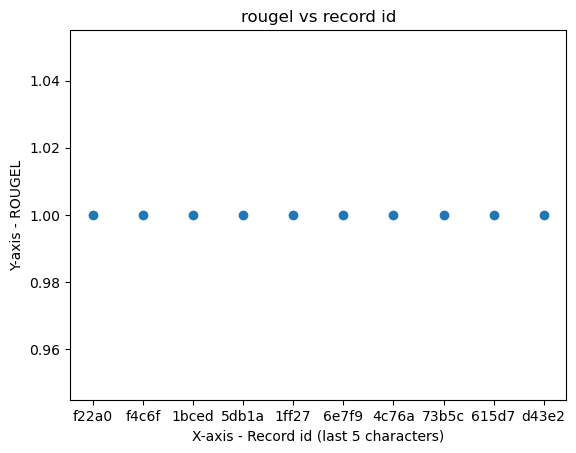

In [86]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougel, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGEL')
plt.title('rougel vs record id')

# Display the graph
plt.show()

Plot Rouge-L Sum Metrics Against Records

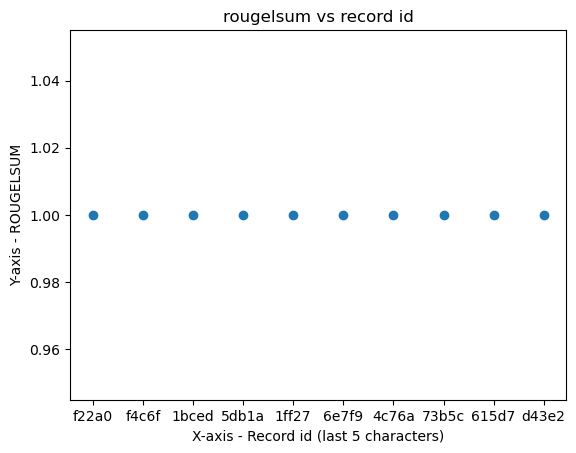

In [87]:
import matplotlib.pyplot as plt
plt.scatter(x, y_rougelsum, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - ROUGELSUM')
plt.title('rougelsum vs record id')

# Display the graph
plt.show()

---
## Display Drift V2 Metrics (PRODUCTION Only)

Review the Drift V2 metrics to evaluate how the model's performance has changed over time in the production environment.


### Read the Drift V2 Monitor Instance ID

Obtain the Drift V2 monitor instance ID to access and review the associated metrics.


In [88]:
monitor_definition_id = "drift_v2"
result = wos_client.monitor_instances.list(data_mart_id = data_mart_id,
                                           monitor_definition_id = monitor_definition_id,
                                           target_target_id = target_target_id,
                                           space_id = target_space_id).result
result_json = result._to_dict()
drift_monitor_id = result_json["monitor_instances"][0]["metadata"]["id"]
drift_monitor_id

'eb496afb-2171-41e3-a1ca-b100ee3318fa'

Displaying the monitor metrics of Drift V2 generated through the risk evaluation.

In [89]:
time.sleep(15)
wos_client.monitor_instances.show_metrics(monitor_instance_id=drift_monitor_id, space_id=target_space_id)

## View Factsheets Information <a name="factsheetsspace"></a>

To access detailed information about your models and evaluations, view the factsheets.

In [91]:
if not use_software:
    factsheets_url = "https://dataplatform.cloud.ibm.com/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(deployment_id, target_space_id)
else:
    factsheets_url = "{}/ml-runtime/deployments/{}/details?space_id={}&context=wx&flush=true".format(Credentials["url"], deployment_id, target_space_id)
    
print("User can navigate to the published facts in space {}".format(factsheets_url))

User can navigate to the published facts in space https://dataplatform.cloud.ibm.com/ml-runtime/deployments/9f0d8e25-4d5b-4d90-86fc-2c16b81ccbd8/details?space_id=bfd9da0c-a0f1-4d2e-80b0-a248502d9d8d&context=wx&flush=true


**Created by:**  


IBM watsonx.governance - *AI Factsheet Python SDK Team* 

---

**Copyright © 2022-2024 IBM**  
Released under the [Apache 2.0 License](https://www.apache.org/licenses/LICENSE-2.0).
